## DS 4420: Final Project
### Predicting Animal Shelter Outcomes

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\Bala Rangasamy\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Cleaning

In [2]:
# load data
austin_animal_center_df = pd.read_csv("austin_animal_center_outcomes.csv")
austin_animal_center_df.head()

,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green
3,A679066,2014-04-16,NaN,2014-05-16T00:00:00-05:00,05-2014,NaN,NaN,Other,Unknown,4 weeks,Rabbit Sh,Brown
4,A680855,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


In [3]:
# general info
austin_animal_center_df.info()
austin_animal_center_df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173775 entries, 0 to 173774
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         173775 non-null  object
 1   Date of Birth     173775 non-null  object
 2   Name              123991 non-null  object
 3   DateTime          173775 non-null  object
 4   MonthYear         173775 non-null  object
 5   Outcome Type      173729 non-null  object
 6   Outcome Subtype   79660 non-null   object
 7   Animal Type       173775 non-null  object
 8   Sex upon Outcome  173774 non-null  object
 9   Age upon Outcome  173766 non-null  object
 10  Breed             173775 non-null  object
 11  Color             173775 non-null  object
dtypes: object(12)
memory usage: 15.9+ MB


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,173775,173775,123991,173775,173775,173729,79660,173775,173774,173766,173775,173775
unique,156237,8692,29756,146382,140,11,26,5,5,55,3010,663
top,A721033,2016-05-01,Luna,2016-04-18T00:00:00-05:00,06-2019,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,121,760,39,2244,84598,40410,94505,60933,28782,34039,17999


In [4]:
# check complete rows
complete_rows = austin_animal_center_df.dropna().shape[0]
complete_rows

43034

In [5]:
# check complete rows besides name
complete_except_name = austin_animal_center_df.dropna(subset=[col for col in austin_animal_center_df.columns if col != 'Name']).shape[0]
complete_except_name

79649

In [6]:
# add 'HasName' column (0=no name, 1=has name)
austin_animal_center_df['HasName'] = austin_animal_center_df['Name'].fillna("").str.strip().ne("").astype(int)

In [7]:
austin_animal_center_df['HasName']

0         0
1         0
2         0
3         0
4         0
         ..
173770    0
173771    0
173772    0
173773    1
173774    0
Name: HasName, Length: 173775, dtype: int32

In [8]:
austin_animal_center_df['Sex upon Outcome'].unique()

array(['Unknown', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Neutered Male', nan], dtype=object)

In [9]:
# separate 'Sex upon Outcome' into 'Sex' and 'IsNeuteredOrSpayed'
def parse_sex_upon_outcome(value):
    if pd.isnull(value) or value == "Unknown":
        return pd.Series([np.nan, np.nan])   # Sex, IsNeuteredOrSpayed

    parts = value.split()
    status = parts[0].lower() # Neutered or Spayed
    sex = parts[1].title()  # Male or Female

    # Neutered or Spayed = 1
    if status in ["spayed", "neutered"]:
        status_num = 1
    # Intact = 0
    elif status == "intact":
        status_num = 0
    else:
        status_num = np.nan

    return pd.Series([sex, status_num])

austin_animal_center_df[['Sex', 'IsNeuteredOrSpayed']] = austin_animal_center_df['Sex upon Outcome'].apply(parse_sex_upon_outcome)

In [10]:
austin_animal_center_df[['Sex upon Outcome', 'Sex', 'IsNeuteredOrSpayed']]

,Sex upon Outcome,Sex,IsNeuteredOrSpayed
0,Unknown,NaN,NaN
1,Unknown,NaN,NaN
2,Unknown,NaN,NaN
3,Unknown,NaN,NaN
4,Unknown,NaN,NaN
...,...,...,...
173770,Spayed Female,Female,1.0
173771,Intact Male,Male,0.0
173772,Unknown,NaN,NaN
173773,Intact Male,Male,0.0


In [11]:
austin_animal_center_df['Outcome Type'].unique()

array(['Transfer', 'Euthanasia', nan, 'Adoption', 'Return to Owner',
       'Died', 'Missing', 'Disposal', 'Relocate', 'Rto-Adopt', 'Stolen',
       'Lost'], dtype=object)

In [12]:
austin_animal_center_df['Outcome Subtype'].unique()

array(['Partner', 'Suffering', nan, 'Foster', 'Offsite', 'In Kennel',
       'Enroute', 'In Foster', 'Aggressive', 'SCRP', 'Rabies Risk',
       'At Vet', 'Possible Theft', 'Medical', 'Snr', 'Field', 'Behavior',
       'Court/Investigation', 'In Surgery', 'Barn', 'Underage',
       'Customer S', 'Out State', 'Emergency', 'Prc', 'Emer', 'In State'],
      dtype=object)

In [13]:
austin_animal_center_df['Animal Type'].unique()

array(['Other', 'Bird', 'Dog', 'Cat', 'Livestock'], dtype=object)

In [14]:
austin_animal_center_df['Age upon Outcome'].unique()

array(['1 year', '2 years', '4 weeks', '2 weeks', '2 months', '5 months',
       '6 months', '8 months', '3 weeks', '5 years', '6 years', '1 weeks',
       '3 years', '13 years', '14 years', '12 years', '1 month',
       '4 months', '10 months', '8 years', '9 years', '3 months',
       '7 years', '4 years', '5 days', '4 days', '1 week', '11 months',
       '7 months', '9 months', '10 years', '3 days', '0 years', '2 days',
       '11 years', '5 weeks', '1 day', '20 years', '25 years', '6 days',
       '17 years', '18 years', '15 years', '16 years', '19 years',
       '22 years', '-1 years', '-3 years', '-2 years', '24 years',
       '-4 years', '21 years', '23 years', '30 years', '28 years', nan],
      dtype=object)

In [15]:
# convert age to years unit
def age_to_years(age_str):
    if pd.isnull(age_str):
        return np.nan
    
    try:
        age_str = age_str.lower().strip()
        # split into number and unit
        parts = age_str.split()
        if len(parts) != 2:
            return np.nan
        
        num, unit = parts
        num = float(num)
        
        # if negative age
        if num < 0:
            return np.nan
        
        # convert to years
        if 'week' in unit:
            return num / 52
        elif 'month' in unit:
            return num / 12
        elif 'year' in unit:
            return num
        else:
            return np.nan
    except:
        return np.nan

In [16]:
austin_animal_center_df['AgeInYears'] = austin_animal_center_df['Age upon Outcome'].apply(age_to_years)

In [17]:
austin_animal_center_df[['AgeInYears']]

,AgeInYears
0,1.000000
1,2.000000
2,1.000000
3,0.076923
4,0.038462
...,...
173770,0.583333
173771,0.083333
173772,0.250000
173773,3.000000


In [18]:
austin_animal_center_df['Breed'].unique()

array(['Turtle Mix', 'Raccoon', 'Rabbit Sh', ..., 'Dachshund/Bulldog',
       'Labrador Retriever/Affenpinscher', 'Pekingese/Lhasa Apso'],
      dtype=object)

In [19]:
austin_animal_center_df['Color'].unique()

array(['Brown/Yellow', 'Black/Gray', 'Green', 'Brown', 'Yellow/Black',
       'Brown/Black', 'Black/White', 'Black', 'White', 'Brown/White',
       'Tan', 'Blue Tabby', 'Chocolate', 'Cream', 'Gray/Black', 'Gold',
       'Blue', 'Red', 'Fawn/White', 'Yellow/White', 'White/Gray',
       'Tricolor', 'Torbie', 'Sable', 'Gray', 'White/Brown', 'Yellow',
       'White/Black', 'White/Chocolate', 'Cream/Black', 'Chocolate/White',
       'White/Red Tick', 'White/Brown Brindle', 'Buff/Gray', 'Black/Tan',
       'Blue Merle/Black', 'Black/Yellow', 'White/Tan', 'Tan/White',
       'Pink', 'Red/White', 'Tan/Brown', 'Calico', 'Brown Tabby/White',
       'Brown Brindle', 'Blue Tick/Black', 'Blue/White', 'Black/Brown',
       'Green/Blue', 'Brown Tabby', 'Orange Tabby', 'Tortie',
       'Blue Merle', 'Black/Tricolor', 'Orange/Tan', 'White/White',
       'Orange Tabby/White', 'Tan/Tan', 'Cream Tabby',
       'Cream Tabby/White', 'Lilac Point', 'Lynx Point', 'Fawn/Black',
       'Black/Buff', 'White/Crea

In [20]:
# create color groups to minimize amount of color categories
color_groups = {
    'Brown': ['Brown', 'Chocolate', 'Sable', 'Fawn', 'Liver', 'Agouti'],
    'Black': ['Black'],
    'Green': ['Green'],
    'Gold': ['Yellow', 'Gold', 'Buff'],
    'White': ['White', 'Flame'],
    'Tan': ['Tan', 'Cream'],
    'Blue': ['Blue'],
    'Gray': ['Gray', 'Silver'],
    'Multicolor': ['Tricolor', 'Torbie', 'Calico', 'Tortie'],
    'Red': ['Pink', 'Red'],
    'Orange': ['Orange', 'Apricot'],
    'White To Black': ['Lilac', 'Lynx', 'Seal']
}

In [21]:
# function to assign color group based on first word in 'Color'
def assign_color_group(color_value):
    if pd.isnull(color_value):
        return np.nan
    
    color_value = color_value.title()
    
    for group, keywords in color_groups.items():
        for kw in keywords:
            if kw in color_value:
                return group
    
    return 'Other'

In [22]:
# assign color group based on first word in 'Color'
austin_animal_center_df['ColorGroup'] = austin_animal_center_df['Color'].apply(assign_color_group)

In [23]:
austin_animal_center_df[['ColorGroup']]

,ColorGroup
0,Brown
1,Black
2,Green
3,Brown
4,Black
...,...
173770,Brown
173771,Brown
173772,Brown
173773,Gold


In [24]:
austin_animal_center_df['ColorGroup'].unique()

array(['Brown', 'Black', 'Green', 'White', 'Tan', 'Blue', 'Gold', 'Red',
       'Multicolor', 'Gray', 'Orange', 'White To Black', 'Other'],
      dtype=object)

In [25]:
# extract month - to see if it influences outcomes
austin_animal_center_df['MonthYear_dt'] = pd.to_datetime(austin_animal_center_df['MonthYear'], format='%m-%Y', errors='coerce')
austin_animal_center_df['Month'] = austin_animal_center_df['MonthYear_dt'].dt.month
austin_animal_center_df = austin_animal_center_df.drop(columns=['MonthYear_dt'])

In [26]:
austin_animal_center_df[['Month']]

,Month
0,12
1,2
2,4
3,5
4,6
...,...
173770,2
173771,3
173772,5
173773,5


In [27]:
# use sine of month to keep each month same distance apart
austin_animal_center_df['Month_sin'] = np.sin(2 * np.pi * austin_animal_center_df['Month']/12)

In [28]:
# keep useful columns - for neural net (start without month)
animal_df = austin_animal_center_df.drop(['Animal ID', 'Date of Birth', 'Name', 'DateTime', 'MonthYear', 'Month', 'Month_sin',
                                          'Outcome Subtype', 'Sex upon Outcome', 'Age upon Outcome', 'Color'], axis=1)

In [29]:
# drop any rows with nulls
animal_df = animal_df.dropna()

In [30]:
animal_df

,Outcome Type,Animal Type,Breed,HasName,Sex,IsNeuteredOrSpayed,AgeInYears,ColorGroup
12,Adoption,Dog,Black Mouth Cur Mix,1,Female,1.0,0.166667,Brown
15,Transfer,Bird,Silkie Mix,0,Male,0.0,0.416667,Black
21,Transfer,Dog,Chihuahua Shorthair Mix,1,Male,0.0,1.000000,Brown
22,Transfer,Bird,Chicken Mix,1,Male,0.0,1.000000,Brown
23,Transfer,Dog,Shiba Inu Mix,0,Male,0.0,0.666667,Tan
...,...,...,...,...,...,...,...,...
173768,Transfer,Cat,Domestic Shorthair Mix,0,Male,0.0,2.000000,Brown
173769,Transfer,Dog,Pekingese,1,Male,0.0,5.000000,White
173770,Transfer,Cat,Domestic Medium Hair Mix,0,Female,1.0,0.583333,Brown
173771,Transfer,Dog,Pomeranian Mix,0,Male,0.0,0.083333,Brown


### EDA

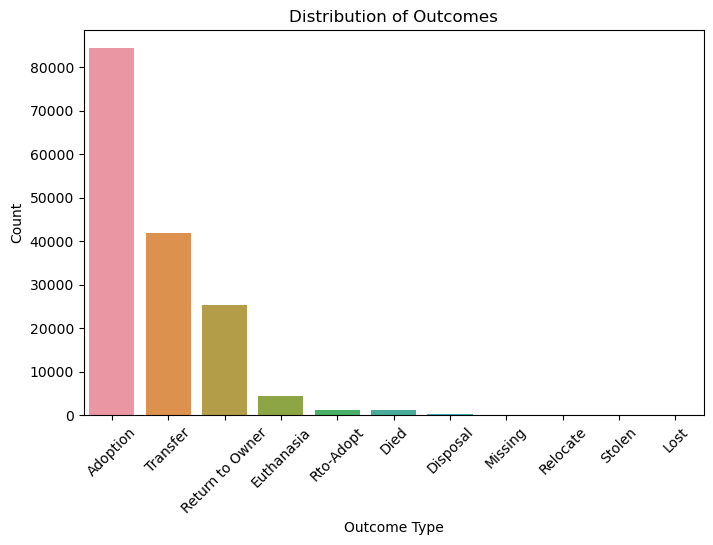

In [31]:
# distribution of outcomes
plt.figure(figsize=(8,5))
sns.countplot(x='Outcome Type', data=animal_df, order=animal_df['Outcome Type'].value_counts().index)
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [32]:
# combine return to owner and rto-adopt
animal_df["Outcome Type"] = animal_df["Outcome Type"].replace({
    "Rto-Adopt": "Return to Owner"
})

In [33]:
# get rid of outcome categories with barely any count
outcomes_drop = ["Missing", "Relocate", "Stolen", "Lost", "Disposal"]

animal_df_reduced = animal_df[~animal_df["Outcome Type"].isin(outcomes_drop)].copy()

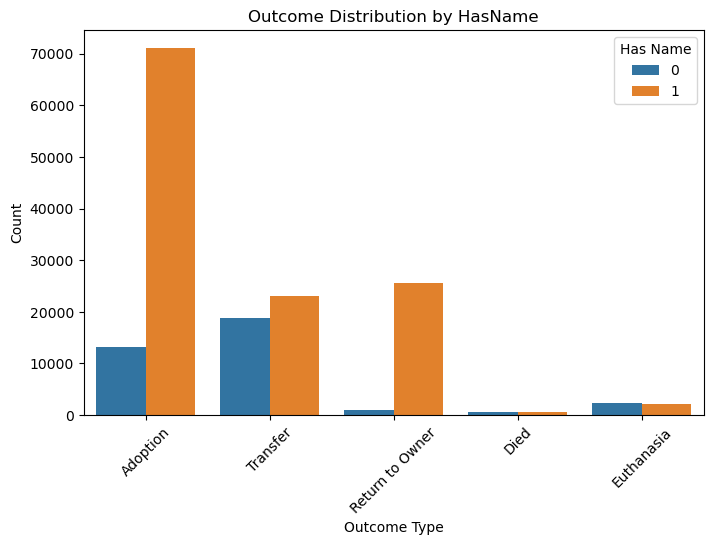

In [34]:
# distribution based on 'HasName'
plt.figure(figsize=(8,5))
sns.countplot(x='Outcome Type', hue='HasName', data=animal_df_reduced)
plt.title('Outcome Distribution by HasName')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.legend(title='Has Name')
plt.xticks(rotation=45)
plt.show()

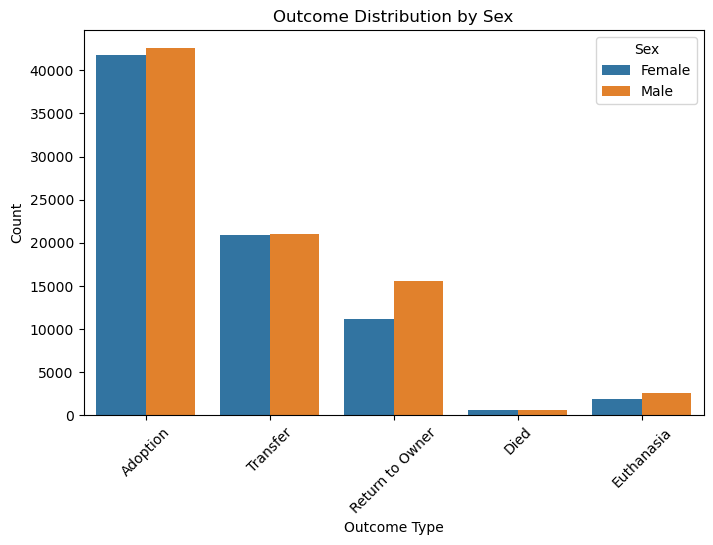

In [35]:
# distribution based on 'Sex'
plt.figure(figsize=(8,5))
sns.countplot(x='Outcome Type', hue='Sex', data=animal_df_reduced)
plt.title('Outcome Distribution by Sex')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45)
plt.show()

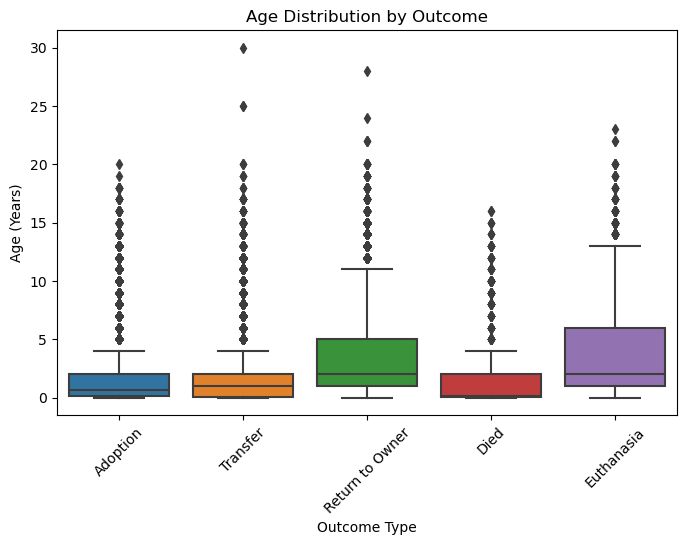

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome Type', y='AgeInYears', data=animal_df_reduced)
plt.title('Age Distribution by Outcome')
plt.xlabel('Outcome Type')
plt.ylabel('Age (Years)')
plt.xticks(rotation=45)
plt.show()

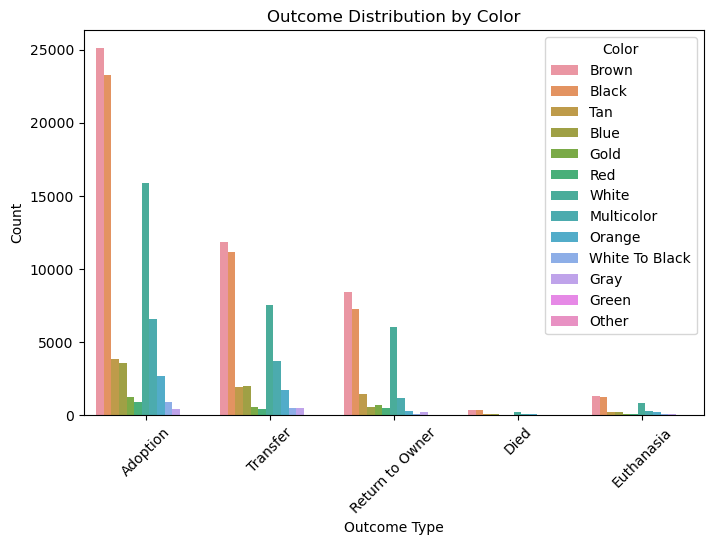

In [37]:
# distribution based on 'ColorGroup'
plt.figure(figsize=(8,5))
sns.countplot(x='Outcome Type', hue='ColorGroup', data=animal_df_reduced)
plt.title('Outcome Distribution by Color')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.legend(title='Color')
plt.xticks(rotation=45)
plt.show()

### Preprocessing

In [38]:
# convert the categorical values into numerical values
for col in ["Animal Type", "Sex", "ColorGroup", "Outcome Type"]:
    le = LabelEncoder()
    animal_df_reduced[col + "_Num"] = le.fit_transform(animal_df_reduced[col])

In [39]:
# set up embeddings for breed
breed_to_idx = {b: i+1 for i, b in enumerate(animal_df_reduced["Breed"].unique())}
breed_to_idx["<UNK>"] = 0

animal_df_reduced["Breed_Embed"] = animal_df_reduced["Breed"].map(breed_to_idx).fillna(0).astype(int)

In [40]:
animal_df_reduced

,Outcome Type,Animal Type,Breed,HasName,Sex,IsNeuteredOrSpayed,AgeInYears,ColorGroup,Animal Type_Num,Sex_Num,ColorGroup_Num,Outcome Type_Num,Breed_Embed
12,Adoption,Dog,Black Mouth Cur Mix,1,Female,1.0,0.166667,Brown,2,0,2,0,1
15,Transfer,Bird,Silkie Mix,0,Male,0.0,0.416667,Black,0,1,0,4,2
21,Transfer,Dog,Chihuahua Shorthair Mix,1,Male,0.0,1.000000,Brown,2,1,2,4,3
22,Transfer,Bird,Chicken Mix,1,Male,0.0,1.000000,Brown,0,1,2,4,4
23,Transfer,Dog,Shiba Inu Mix,0,Male,0.0,0.666667,Tan,2,1,10,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173768,Transfer,Cat,Domestic Shorthair Mix,0,Male,0.0,2.000000,Brown,1,1,2,4,6
173769,Transfer,Dog,Pekingese,1,Male,0.0,5.000000,White,2,1,11,4,344
173770,Transfer,Cat,Domestic Medium Hair Mix,0,Female,1.0,0.583333,Brown,1,0,2,4,45
173771,Transfer,Dog,Pomeranian Mix,0,Male,0.0,0.083333,Brown,2,1,2,4,91


In [41]:
# split target and features
X = animal_df_reduced[['Animal Type_Num', 'HasName', 'Sex_Num', 'IsNeuteredOrSpayed', 'ColorGroup_Num', 'AgeInYears', 'Breed_Embed']]
y = animal_df_reduced['Outcome Type_Num'].values

In [42]:
# one-hot encode y
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(y.reshape(-1, 1)) 

In [43]:
# split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# scale numerical columns
num_cols = ['AgeInYears']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Modeling

In [45]:
# number of unique breeds in the embedding
n_breeds = X_train["Breed_Embed"].max() + 1  # since 0 = <UNK>

# number of numeric features
n_features = X_train.drop(columns=["Breed_Embed"]).shape[1]

In [46]:
# breed embedding layer for input
input_breed = tf.keras.Input(shape=(1,), name="Breed_Embed")
embed = layers.Embedding(input_dim=n_breeds, output_dim=16)(input_breed)
embed = layers.Flatten()(embed)

# rest of the input includes all other features
input_other = tf.keras.Input(shape=(n_features,), name="Other_Features")

# hidden layers
x = layers.Dense(64, activation="relu")(input_other)
x = layers.Dense(32, activation="relu")(x)

# combine breed embedding layer with rest of inputs for final hidden layer
combined = layers.Concatenate()([embed, x])
h = layers.Dense(64, activation="relu")(combined)

# output layer (softmax for multi-class)
k = y_train.shape[1]  # number of classes
output = layers.Dense(k, activation="softmax")(h)

# build model
model = Model(
    inputs=[input_breed, input_other],
    outputs=output
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Breed_Embed (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Other_Features (InputLayer)   │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 16)             │          46,832 │ Breed_Embed[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             448 │ Other_Features[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 16)                │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           2,080 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 48)                │               0 │ flatten[0][0],             │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           3,136 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 5)                 │             325 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 52,821 (206.33 KB)

 Trainable params: 52,821 (206.33 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# run model
history = model.fit(
    {"Breed_Embed": X_train["Breed_Embed"], 
     "Other_Features": X_train.drop(columns=["Breed_Embed"])},
    y_train,
    epochs=30,
    batch_size=256,
)

Epoch 1/30


C:\Users\Bala Rangasamy\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Breed_Embed', 'Other_Features']. Received: the structure of inputs={'Breed_Embed': '*', 'Other_Features': '*'}
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6406 - loss: 0.9471
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7075 - loss: 0.7646
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7148 - loss: 0.7516
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7185 - loss: 0.7389
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7187 - loss: 0.7348
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7213 - loss: 0.7295
Epoch 7/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7223 - loss: 0.7249
Epoch 8/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7217 - loss: 0.7269
Epoch 9/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7255 - loss: 0.7163
Epoch 10/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7249 - loss: 0.7170
Epoch 11/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7240 - loss: 0.7169
Epoch 12/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

In [48]:
# check loss and accuracy on test set
test_loss, test_acc = model.evaluate(
    {
        "Breed_Embed": X_test["Breed_Embed"],
        "Other_Features": X_test.drop(columns=["Breed_Embed"])
    },
    y_test
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

C:\Users\Bala Rangasamy\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Breed_Embed', 'Other_Features']. Received: the structure of inputs={'Breed_Embed': '*', 'Other_Features': '*'}
  warnings.warn(


991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7143 - loss: 0.7753
Test Loss: 0.7840868234634399
Test Accuracy: 0.7105188369750977


In [52]:
# predict on test set
y_pred_probs = model.predict(
    {"Breed_Embed": X_test["Breed_Embed"], 
     "Other_Features": X_test.drop(columns=["Breed_Embed"])}
)

# convert softmax probabilities to class
y_pred_classes = y_pred_probs.argmax(axis=1)

# convert one-hot true values from test set to class
y_true_classes = y_test.argmax(axis=1)

991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [53]:
# compute additional metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average="weighted")
recall = recall_score(y_true_classes, y_pred_classes, average="weighted")
f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7105188456079483
Precision: 0.6870075016947169
Recall: 0.7105188456079483
F1 Score: 0.6830272460072011


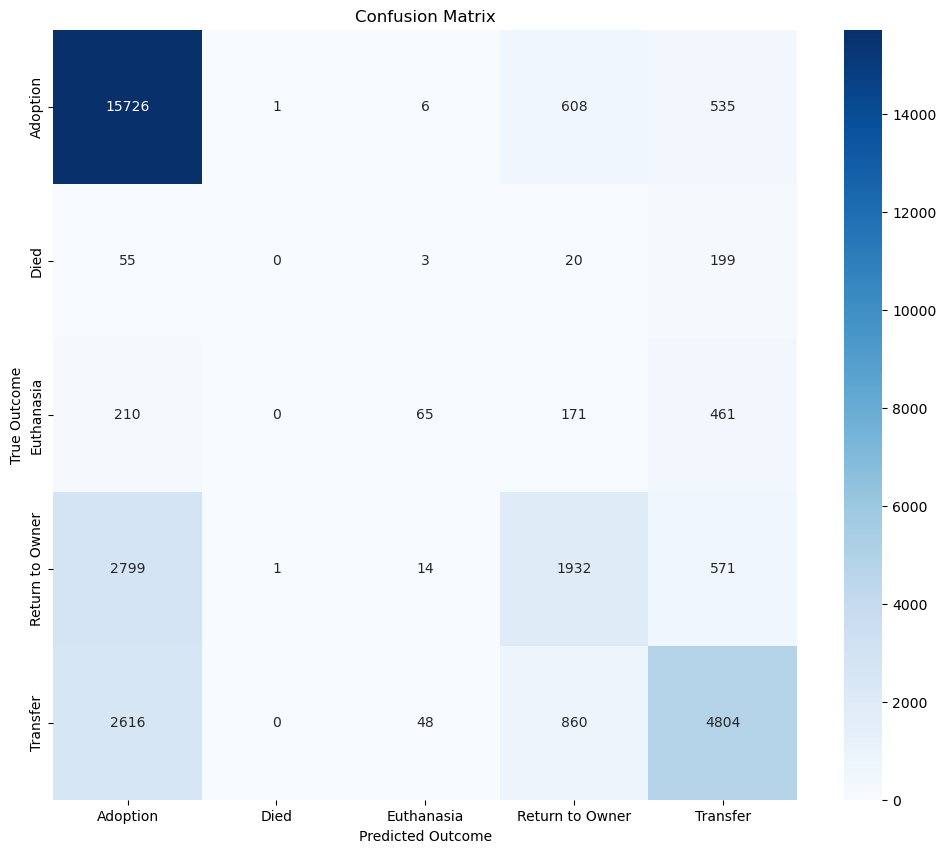

In [54]:
# display confusion matrix for metrics
outcome_names = animal_df_reduced["Outcome Type"].unique()  # raw names
outcome_names_ordered = sorted(outcome_names)

# compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=outcome_names_ordered, yticklabels=outcome_names_ordered)
plt.xlabel('Predicted Outcome')
plt.ylabel('True Outcome')
plt.title('Confusion Matrix')
plt.show()